# The ElasticNet results (for the most abundant cell types)

## Outline

The **MLAging - cell type** workflow consists of sections:

`00 preprocessing.R` Data preprocessing and preparation in Seurat.

`21 Cell Type ELN Tuning` ELN model tunning using *binarized* HVGs and hyperparameter selection using `GridSearchCV`.

`22 Cell Type ELN Result 10x` Run the best models for *binarized* HVGs over 10 random seeds.

`23 Cell Type Result Viz` Result visulization -- **this notebook**:

1. [Performance (AUPRC) bar plots](#1.-barplot)
2. [Precision-Recall curve](#2.-prcurve)


`24 Cell Type Interpretations` Result interpretation. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from statistics import mean, stdev
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from src.data_processing import *
from src.grid_search import *

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')

## 1. Performance (AUPRC) bar plots <a name="1.-barplot"></a>

In [2]:
cell_types = ['Neuron', 'Oligodendrocyte', 'Astrocyte', 'OPC', 'Microglia']
for i in cell_types:
    file = open('../results/cell_type_best/' + i + '_eln_model_test_scores.save', 'rb')
    locals()[i]  = pickle.load(file)
    file.close()

In [3]:
baseline_df = []
for i in cell_types:
    file = open('../results/cell_type_best/' + i + '_eln_model_test_sets.save', 'rb')
    final  = pickle.load(file)
    X_test, y_test = final[0]
    baseline_df.append(max(y_test.value_counts())/len(y_test))
    file.close()

In [5]:
baseline_df = []
for i in cell_types:
    file = open('../results/cell_type_best/' + i + '_eln_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    model  = all_10_files[0]
    file.close()
    
    file = open('../results/cell_type_best/' + i + '_eln_model_test_sets.save', 'rb')
    final  = pickle.load(file)
    X_test, y_test = final[0]
    
    a = model.predict_proba(X_test)[:,1]
    a = a *0 + 1
    precision, recall, thresholds = precision_recall_curve(y_test, a)
    baseline =  auc(recall, precision)
    print(baseline)
    baseline_df.append(baseline)

0.8319589772018572
0.8549134734239803
0.7764388489208633
0.8368580060422961
0.8254237288135593


In [6]:
df_bar = pd.DataFrame(columns=['Cell-type', 'Condition', 'AUPRC'])

for i in cell_types:
    df_new = pd.DataFrame(columns=['Cell-type', 'Condition', 'AUPRC'], index=range(0, 10))
    df_new['Cell-type'] = i
    df_new['Condition'] = 'Baseline'  
    df_new['AUPRC'] = baseline_df[cell_types.index(i)]
    df_bar = df_bar.append(df_new)

In [7]:
for i in cell_types:
    df_new = pd.DataFrame(columns=['Cell-type', 'Condition', 'AUPRC'], index=range(0, 10))
    df_new['Cell-type'] = i
    df_new['Condition'] = 'ELN test'
    df_new['AUPRC'] = locals()[i]
    df_bar = df_bar.append(df_new)

In [8]:
df_bar

,Cell-type,Condition,AUPRC
0,Neuron,Baseline,0.831959
1,Neuron,Baseline,0.831959
2,Neuron,Baseline,0.831959
3,Neuron,Baseline,0.831959
4,Neuron,Baseline,0.831959
...,...,...,...
5,Microglia,ELN test,0.996895
6,Microglia,ELN test,0.996890
7,Microglia,ELN test,0.996895
8,Microglia,ELN test,0.996895


In [11]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

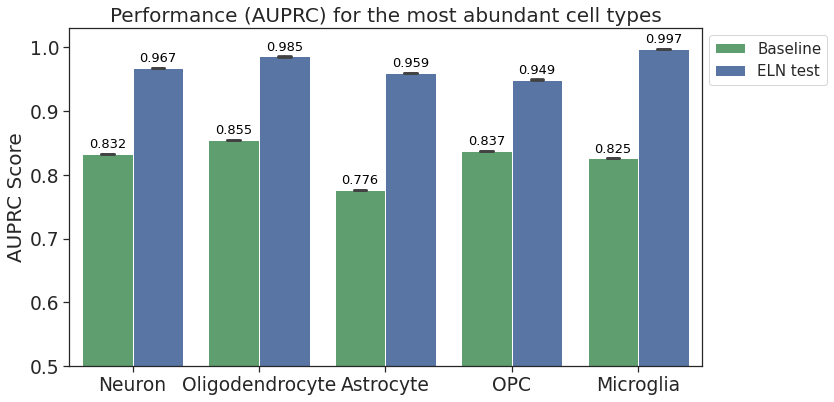

In [14]:
sns.color_palette()

plt.figure(figsize=(12,6))
sns.set(font_scale=1.7, style='ticks')

ax = sns.barplot(data=df_bar, x='Cell-type', y='AUPRC', hue='Condition', ci='sd', capsize=.1, 
                 palette=[sns.color_palette()[2], sns.color_palette()[0]])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height()+0.005, '{0:.3f}'.format(p.get_height()), 
        fontsize=13, color='black', ha='center', va='bottom')

plt.title('Performance (AUPRC) for the most abundant cell types', fontsize=20)
plt.xlabel("", fontsize=20)
plt.ylabel("AUPRC Score", fontsize=20)
plt.ylim(0.5, 1.03)
plt.legend(title='', bbox_to_anchor=(1, 1), fontsize=15)
plt.tight_layout()
plt.savefig('../figures/4b_celltypes_bar_AUPRC_2.pdf')
plt.show()

## 2. Precision-Recall Curve <a name="2.-prcurve"></a>

In [16]:
# for ML models
def calculate_MLPR(ML_model, test_X, test_y):
    y_test_prob = ML_model.predict_proba(test_X)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_y, y_test_prob)
    return recall, precision, auc(recall, precision)

In [17]:
for i in cell_types:
    file = open('../results/cell_type_best/' + i + '_eln_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    model  = all_10_files[0]
    file.close()
    
    file = open('../results/cell_type_best/' + i + '_eln_model_test_sets.save', 'rb')
    final  = pickle.load(file)
    X_test, y_test = final[0]
    file.close()
    locals()[i] = calculate_MLPR(model, X_test, y_test)

In [15]:
baseline_df

[0.8319589772018572,
 0.8549134734239803,
 0.7764388489208633,
 0.8368580060422961,
 0.8254237288135593]

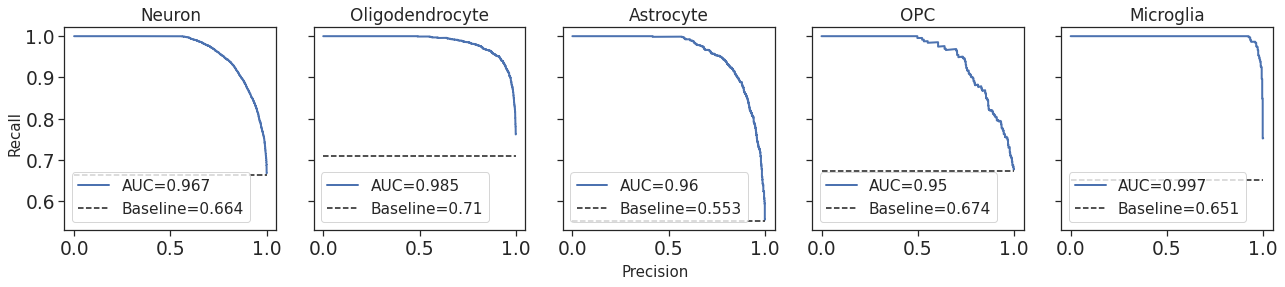

In [10]:
fig, axs  = plt.subplots(1,5, figsize=(18,4), sharey=True)
sns.set(font_scale=1.4, style='ticks')

for i in cell_types:
    recall, precision, auprc = locals()[i]
    baseline = baseline_df[cell_types.index(i)]
    
    number = cell_types.index(i)
    axs[number].plot(recall, precision,
                     label=f'AUC={round(auprc, 3)}',lw=2)
    axs[number].plot([0, 1], [baseline, baseline], 'k--' , label=f"Baseline={round(baseline, 3)}")
    
    axs[number].set_title(f'{i}')
    axs[number].legend(loc='lower left')
#     axs[number].legend(bbox_to_anchor=(0.9, 0.4))

fig.text(0.5, 0.0, 'Precision', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Recall', va='center', rotation='vertical', fontsize=15)

# plt.rcParams.update({'font.size': 10})   
plt.tight_layout()
# plt.savefig('../figures/4c_celltype_auprc.pdf')
plt.show()

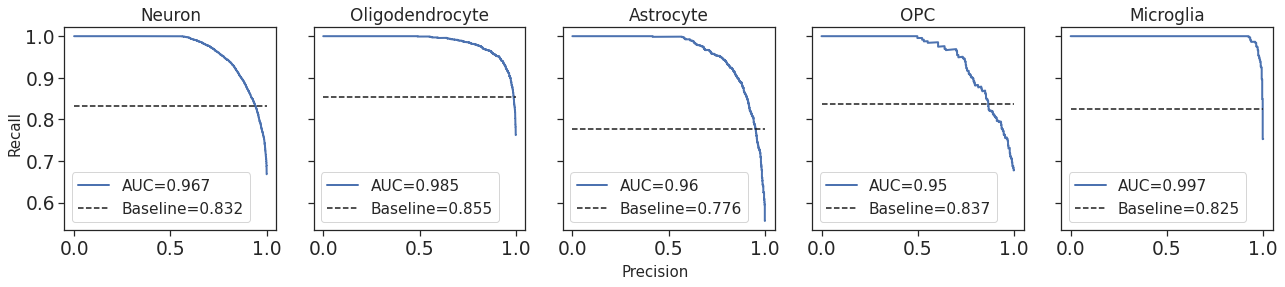

In [19]:
fig, axs  = plt.subplots(1,5, figsize=(18,4), sharey=True)
sns.set(font_scale=1.4, style='ticks')

for i in cell_types:
    recall, precision, auprc = locals()[i]
    baseline = baseline_df[cell_types.index(i)]
    
    number = cell_types.index(i)
    axs[number].plot(recall, precision,
                     label=f'AUC={round(auprc, 3)}',lw=2)
    axs[number].plot([0, 1], [baseline, baseline], 'k--' , label=f"Baseline={round(baseline, 3)}")
    
    axs[number].set_title(f'{i}')
    axs[number].legend(loc='lower left')
#     axs[number].legend(bbox_to_anchor=(0.9, 0.4))

fig.text(0.5, 0.0, 'Precision', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Recall', va='center', rotation='vertical', fontsize=15)

# plt.rcParams.update({'font.size': 10})   
plt.tight_layout()
plt.savefig('../figures/4c_celltype_auprc_2.pdf')
plt.show()